Multifrequency and Doppler Radar Example
====================================

Initialize the calculations by loading some basic modules. And define some useful functions.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
begin = datetime.datetime.now()

import snowScatt

from snowScatt.instrumentSimulator.radarMoments import Ze
from snowScatt.instrumentSimulator.radarSpectrum import dopplerSpectrum
from snowScatt.instrumentSimulator.radarSpectrum import sizeSpectrum


def Nexp(D, lam):
    return np.exp(-lam*D)/lam # basic implementation of an inverse exponential size distribution

def dB(x):
    return 10.0*np.log10(x)

def Bd(x):
    return 10.0**(0.1*x)

Set the parameters of the calculation. The frequencies (in Herz), the vector of sizes for which the snow properties (backscatter, fallspeed and concentration) are gonna be calculated.
Set additional parameters for the computation

/home/dori/.local/lib/python3.8/site-packages/snowScatt/instrumentSimulator/radarMoments.py:44: RuntimeWarning: invalid value encountered in log10
  return 10.0*np.log10(x)
<ipython-input-15-123f4739ebbb>:18: RuntimeWarning: invalid value encountered in log10
  return 10.0*np.log10(x)


Execution  0:00:01.137161


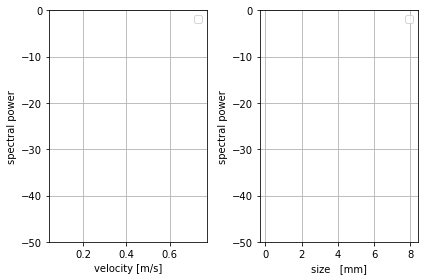

In [16]:
frequency =  np.array([13.6e9, 35.6e9, 94.0e9]) # frequencies
temperature = 270.0

Dmax = np.linspace(0.1e-3, 8.0e-3, 1000) # list of sizes [meters]
lams = 1.0/np.linspace(0.01-3, 0.5e-3, 10) # list of lambdas [meters**-1]

particle = 'Leinonen15tabA00'
fig, (ax0, ax1) = plt.subplots(1, 2)
PSD = 10.0*np.stack([np.array(Nexp(Dmax, l)) for l in lams])

wl = snowScatt._compute._c/frequency[0]
spec0, vel = dopplerSpectrum(Dmax, PSD, wl, particle, temperature=temperature)
spec1 = sizeSpectrum(Dmax, PSD, wl, particle, temperature=temperature)

Zx = Ze(Dmax, PSD, wl, particle, temperature=temperature)

ax0.plot(vel, dB(spec0.T))
ax1.plot(Dmax*1.0e3, dB(spec1.T))
for ax in (ax0, ax1):
    ax.legend()
    ax.grid()
    ax.set_ylabel('spectral power')
    ax.set_ylim([-50, 0])
ax0.set_xlabel('velocity [m/s]')
ax1.set_xlabel('size   [mm]')
fig.tight_layout()
print('Execution ', datetime.datetime.now()-begin)

Z0 = dB(np.nansum((spec0*np.gradient(vel)), axis=-1))
Z1 = dB(np.nansum((spec1*np.gradient(Dmax)), axis=-1)) # chack that Z0 and Z1 are equal

In [18]:
PSD

array([[-2.99010000e+01, -2.99010791e+01, -2.99011582e+01, ...,
        -2.99799485e+01, -2.99800278e+01, -2.99801071e+01],
       [-2.65782222e+01, -2.65783013e+01, -2.65783804e+01, ...,
        -2.66571841e+01, -2.66572634e+01, -2.66573427e+01],
       [-2.32554445e+01, -2.32555235e+01, -2.32556026e+01, ...,
        -2.33344235e+01, -2.33345029e+01, -2.33345822e+01],
       ...,
       [-6.64155563e+00, -6.64163472e+00, -6.64171381e+00, ...,
        -6.72087931e+00, -6.72095935e+00, -6.72103938e+00],
       [-3.31877793e+00, -3.31885703e+00, -3.31893614e+00, ...,
        -3.39858806e+00, -3.39866907e+00, -3.39875008e+00],
       [ 4.09365377e-03,  4.02941860e-03,  3.96619137e-03, ...,
         5.80758717e-10,  5.71645798e-10,  5.62675874e-10]])

In [20]:
vel.shape

(1000,)

Execution  0:03:35.482778


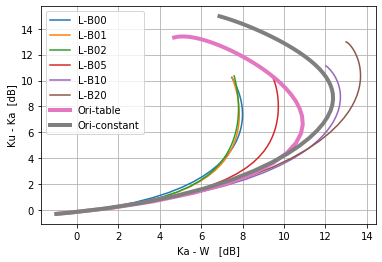

In [21]:
frequency =  np.array([13.6e9, 35.6e9, 94.0e9]) # frequencies
temperature = 270.0
Nangles = 721

Dmax = np.linspace(0.1e-3, 20.0e-3, 1000) # list of sizes
lams = 1.0/np.linspace(0.01e-3, 11.0e-3, 100)

rime = ['00', '01', '02', '05', '10', '20']
particles = 'Leinonen15tabB'
fig, (ax0) = plt.subplots(1, 1)
# 
PSD = np.stack([np.array(Nexp(Dmax, l)) for l in lams])
for r in rime:
    particle = particles + r
    bck = pd.DataFrame(index=Dmax, columns=frequency)
    for fi, freq in enumerate(frequency):
        wl = snowScatt._compute._c/freq
        eps = snowScatt.refractiveIndex.water.eps(temperature, freq, 'Turner')
        K2 = snowScatt.refractiveIndex.utilities.K2(eps)
        ssCbck, ssvel = snowScatt.backscatVel(diameters=Dmax,
                                              wavelength=wl,
                                              properties=particle,
                                              temperature=temperature)
        bck[freq] = wl**4*ssCbck/(K2*np.pi**5)

    Zx = np.array([dB((1.0e18*bck.iloc[:, 0]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
    Zk = np.array([dB((1.0e18*bck.iloc[:, 1]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
    Zw = np.array([dB((1.0e18*bck.iloc[:, 2]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
    
    ax0.plot(Zk-Zw, Zx-Zk, label='L-B'+r)

particle = 'Ori_collColumns'
bck = pd.DataFrame(index=Dmax, columns=frequency)
for fi, freq in enumerate(frequency):
    wl = snowScatt._compute._c/freq
    eps = snowScatt.refractiveIndex.water.eps(temperature, freq, 'Turner')
    K2 = snowScatt.refractiveIndex.utilities.K2(eps)
    ssCbck, ssvel = snowScatt.backscatVel(diameters=Dmax,
                                          wavelength=wl,
                                          properties=particle,
                                          temperature=temperature)
    bck[freq] = wl**4*ssCbck/(K2*np.pi**5)
Zx = np.array([dB((1.0e18*bck.iloc[:, 0]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zk = np.array([dB((1.0e18*bck.iloc[:, 1]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zw = np.array([dB((1.0e18*bck.iloc[:, 2]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
ax0.plot(Zk-Zw, Zx-Zk, label='Ori-table', lw=4)

particle = 'Oea14'
bck = pd.DataFrame(index=Dmax, columns=frequency)
for fi, freq in enumerate(frequency):
    wl = snowScatt._compute._c/freq
    eps = snowScatt.refractiveIndex.water.eps(temperature, freq, 'Turner')
    K2 = snowScatt.refractiveIndex.utilities.K2(eps)
    ssCbck, ssvel = snowScatt.backscatVel(diameters=Dmax,
                                          wavelength=wl,
                                          properties=particle,
                                          temperature=temperature)
    bck[freq] = wl**4*ssCbck/(K2*np.pi**5)
Zx = np.array([dB((1.0e18*bck.iloc[:, 0]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zk = np.array([dB((1.0e18*bck.iloc[:, 1]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zw = np.array([dB((1.0e18*bck.iloc[:, 2]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
ax0.plot(Zk-Zw, Zx-Zk, label='Ori-constant', lw=4)

for ax in [ax0,]:
    ax.legend()
    ax.grid()
    ax.set_xlabel('Ka - W   [dB]')
    ax.set_ylabel('Ku - Ka  [dB]')
fig.savefig('OriVSOri.png', dpi=300)
print('Execution ', datetime.datetime.now()-begin)